In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
resume_dataset_path = kagglehub.dataset_download('snehaanbhawal/resume-dataset')
linkedin_job_postings_path = kagglehub.dataset_download('arshkon/linkedin-job-postings')

print('Data source import complete.')

Data source import complete.


## Intelligent Resume Filtering Tool for Recruiters

The goal of this project is to build a talent matching system that accurately matches
candidates’ resumes with job descriptions to assess whether a candidate is a good fit
for a given role. This problem will be approached using two distinct methodologies: one employing traditional machine learning and natural language processing (NLP) techniques and another utilizing GPT models.

The traditional approach will involve feature extraction using NLP techniques such as TF-IDF, word embeddings (Word2Vec or GloVe), and classification algorithms such as logistic regression, support vector machines (SVM), or random forests. On the other hand, the system using GPT will leverage advanced language models to comprehend and interpret the semantic meaning of resumes and job descriptions, providing an intelligent match based on context and skills alignment.

Throughout the project, we will implement both solutions, evaluate their performance using key metrics such as accuracy, precision, recall, and F1-score, and measure computational efficiency. The outcomes of these two approaches will be compared to determine which method yields better performance in terms of predictive power, scalability, and adaptability to various industries.

By the end of this project, we aim to provide insights into the effectiveness of state-of-the-art language models like GPT compared to more conventional machine learning techniques in the domain of talent matching. These results will help guide future applications in AI-powered recruitment systems.


___________
### Part 1: Filtering using Traditional ML Techniques

First, we will input the dataset of 12000 resumes to our notebook.

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resume-dataset/Resume/Resume.csv
/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/13998435.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/67582956.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/34349255.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/26790545.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/12674307.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11807040.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/44145704.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/27497542.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11155153.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/17555081.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/41506705.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/54201930.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/24583187.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/38565119.pdf
/kaggle/input/resume-dataset/data/data

In [6]:
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')

In [7]:
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [8]:
!pip install transformers
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.9 MB/s eta 0:00:00


In [9]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
import pandas as pd
from PyPDF2 import PdfReader
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [10]:
resume_data = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')
resume_data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


### EDA and Visualizing the Resume Dataset Distribution

In [11]:
resume_data.describe().T
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


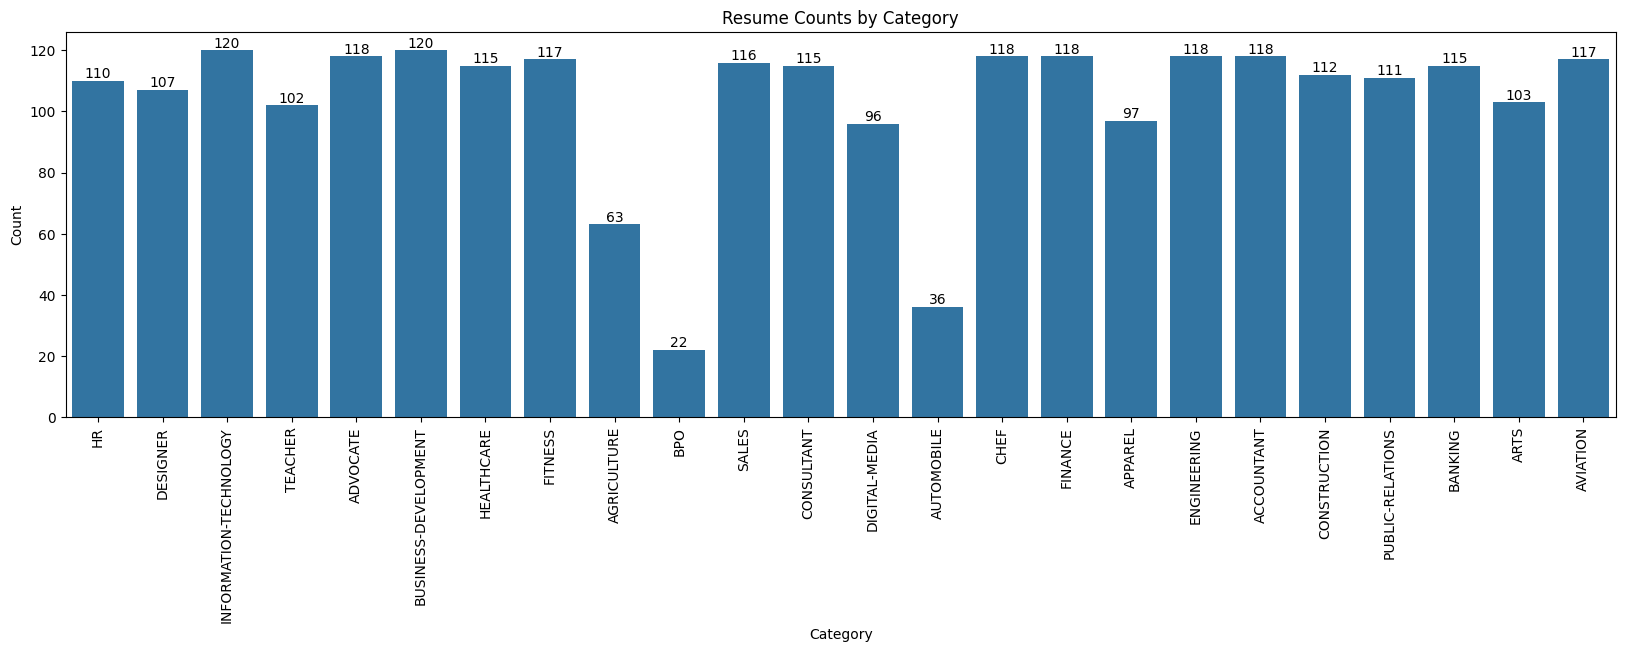

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size and rotation for x-ticks
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)

# Create a count plot
ax = sns.countplot(x="Category", data=resume_data)

# Annotate each bar with its height (the count value)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add gridlines for clarity
plt.title("Resume Counts by Category")
plt.ylabel("Count")
plt.xlabel("Category")

# Show the plot
plt.show()

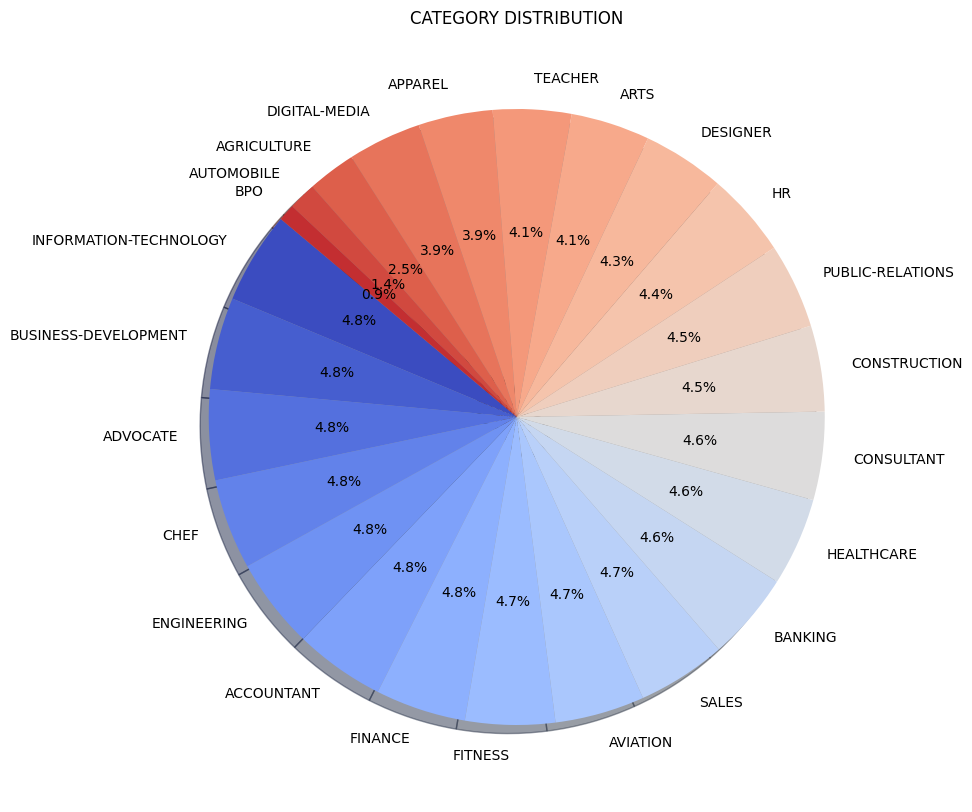

In [13]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# Get category counts and labels
targetCounts = resume_data['Category'].value_counts()
targetLabels = targetCounts.index  # Ensures labels align with counts

# Create a figure
plt.figure(1, figsize=(22, 22))
the_grid = GridSpec(2, 2)

# Generate a colormap
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i / len(targetCounts)) for i in range(len(targetCounts))]

# Plot the pie chart
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')
plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors, startangle=140)

# Show the plot
plt.show()

In [14]:
resume_data = resume_data.drop(["Resume_html"], axis=1)
resume_data.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


### Functions for processing the resumes from the pdf files and preprocessing

In [15]:
def extract_text_from_pdf(file_path):
    reader = PdfReader(file_path)
    text = "".join(page.extract_text() for page in reader.pages)
    return text

In [16]:
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        if any(criteria in sent for criteria in ['skills', 'education']):
            words = word_tokenize(sent)
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
            features['feature'] += " ".join(filtered_words)
    return features

In [17]:
def process_resume_data(df):
    id = df['ID']
    category = df['Category']
    text = extract_text_from_pdf(f"/kaggle/input/resume-dataset/data/data/{category}/{id}.pdf")
    features = preprocess_text(text)
    df['Feature'] = features['feature']
    return df

In [18]:
def get_embeddings(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().to("cpu").numpy()
    return embeddings

In [19]:
def print_top_matching_resumes(result_group):
    for i in range(15):
        print("\nJob ID:", i)
        print("Cosine Similarity | Domain Resume | Domain Description")
        print(result_group.get_group(i)[['similarity', 'domainResume', 'domainDesc']])

--------
#### Preprocessing the resume data

In [20]:
#resume_data.head()
#Identify Duplicates in the Dataset
resume_data.duplicated(subset=['Resume_str']).value_counts()

,count
False,2482
True,2


In [21]:
#remove the duplicates from the dataset
resume_data = resume_data.drop_duplicates(subset=['Resume_str'], keep='first')
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2482 entries, 0 to 2482
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2482 non-null   int64 
 1   Resume_str  2482 non-null   object
 2   Category    2482 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


In [ ]:
!pip install swifter
import swifter
resume_data = resume_data.swifter.apply(process_resume_data, axis=1)
resume_data.head()

In [ ]:
resume_data = resume_data.drop(columns=['Resume_str'])
resume_data.head()

In [ ]:
import nltk
from nltk.probability import FreqDist

# Get the most common words
def print_most_frequent_words(text, top_n=50):
    words = nltk.word_tokenize(text)
    wordfreqdist = FreqDist(words)
    mostcommon = wordfreqdist.most_common(top_n)
    for word, freq in mostcommon:
        print(f"{word}: {freq}")

combined_text = " ".join(resume_data['Feature'].astype(str))
print_most_frequent_words(combined_text)

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

_____________
#### Preprocessing the company_industries (used to filter out job descriptions from matching industries that validate our resume data)

In [ ]:
company_industries = pd.read_csv("/kaggle/input/linkedin-job-postings/companies/company_industries.csv")
company_industries.head()

In [ ]:
company_industries.info()

In [ ]:
desired_industries = ["IT Services and IT Consulting", "Financial Services", "Real Estate", "Banking"]

Processing of Job Descriptions takes longer time, so we will choose a smaller subset of JDs to carry on with out experiment.

To optimize the output of our results, we will use Company_industries table to filter out JDs to keep only a few industries that we will test our code on (also after looking at which industries we readily have in our resume_dataset)

In [ ]:
filtered_industries = company_industries[company_industries['industry'].isin(desired_industries)]
filtered_industries.info()

--------------
#### Preprocessing Job Postings Dataset (Linkedin)

In [ ]:
job_posts = pd.read_csv('/kaggle/input/linkedin-job-postings/postings.csv')
job_posts.head()

In [ ]:
job_posts = job_posts[["job_id","company_id","company_name","title","description","skills_desc"]]
job_posts.head()

In [ ]:
print(job_posts["skills_desc"][12])

In [ ]:
job_descriptions = job_posts[["description","skills_desc","title","company_id"]]
job_descriptions.head()

In [ ]:
job_descriptions.info()

In [ ]:
job_descriptions.isnull().sum()

In [ ]:
job_descriptions = job_descriptions.dropna()
job_descriptions.isnull().sum()

In [ ]:
from wordcloud import WordCloud

# Combine all skills into a single string
all_skills = " ".join(job_descriptions['skills_desc'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_skills)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Skills')
plt.show()

In [ ]:
# Countplot for top 10 most frequent companies
plt.figure(figsize=(12, 6))
sns.countplot(
    y='company_name',
    data=job_posts,
    order=job_posts['company_name'].value_counts().index[:10],
    palette='viridis'
)
plt.title('Top 10 Companies by Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Company Name')
plt.show()

In [ ]:
job_descriptions_filtered = job_descriptions.merge(filtered_industries[['company_id']], on='company_id', how='inner')

In [ ]:
job_descriptions_filtered.info()

In [ ]:
job_descriptions_filtered.head()

In [ ]:
job_descriptions2 = job_descriptions_filtered.dropna()
job_descriptions2.head()
job_descriptions2.info()

In [ ]:
print(job_descriptions2['description'].apply(type).value_counts())

In [ ]:
# Drop rows where 'description' is not a string
job_descriptions2 = job_descriptions2[job_descriptions2['description'].apply(lambda x: isinstance(x, str))]

In [ ]:
#tweaked for JDs
def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        # Tokenize, remove stopwords, and filter by POS tags
        words = word_tokenize(sent)
        words = [word for word in words if word not in stop_words]
        tagged_words = pos_tag(words)
        filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
        features['feature'] += " ".join(filtered_words) + " "
    return features

In [ ]:
job_descriptions2['jdFeatures'] = job_descriptions2['description'].apply(lambda x : preprocess_text(x)['feature'])
job_descriptions2['skillFeatures'] = job_descriptions2['skills_desc'].apply(lambda x : preprocess_text(x)['feature'])
job_descriptions2.head()

In [ ]:
#Replacing empty string with Null
job_descriptions2['jdFeatures'] = job_descriptions2['jdFeatures'].replace(r'^\s*$', np.nan, regex=True)
job_descriptions2['skillFeatures'] = job_descriptions2['skillFeatures'].replace(r'^\s*$', np.nan, regex=True)
job_descriptions2.head()

In [ ]:
job_descriptions2.isnull().sum()

In [ ]:
job_descriptions2.info()

In [ ]:
job_descriptions2 = job_descriptions2.drop(columns=["skills_desc","skillFeatures"],axis=1)
job_descriptions2.head()

In [ ]:
job_descriptions2 = job_descriptions2.dropna(subset=['jdFeatures'])
job_descriptions2.info()

-------
### **Part 2: Matching Resumes with JDs**

Now we will try TF IDF, LDA, and Word Embeddings with Cosine Similarity to match Resumes to JDs

#### Approach 1: TF-IDF Vectorization and then finding similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all text data for fitting the vectorizer
corpus = list(resume_data['Feature']) + list(job_descriptions2['jdFeatures'])

# Initialize and fit TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(corpus)

# Split the TF-IDF matrix into resumes and job descriptions
resume_tfidf = tfidf_matrix[:len(resume_data)]
job_tfidf = tfidf_matrix[len(resume_data):]

In [ ]:
print(resume_tfidf)

#### Similarity Measurement - Using Cosine Similarity to match resumes with job descriptions

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_similarity_matrix = cosine_similarity(job_tfidf, resume_tfidf)

# Get top 5 resumes for each job description
for job_idx in range(5,15):
    top_resumes = tfidf_similarity_matrix[job_idx].argsort()[::-1][:5]
    print(f"Job: {job_descriptions2['title'].iloc[job_idx]}")
    for idx in top_resumes:
        print(f"  Resume ID: {resume_data['ID'].iloc[idx]}, Similarity: {tfidf_similarity_matrix[job_idx][idx]:.4f}")

In [ ]:
check_orig_resume = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')
check_orig_resume.head()

In [ ]:
print("Job: Engineering Project Manager | Similarity: 0.3897")
resume_row = check_orig_resume[check_orig_resume['ID'] == 28697203]
print()
print(resume_row['Resume_str'].iloc[0])

In [ ]:
resume_row

------
#### Approach 2: Topic Modeling (LDA) to extract topics from resumes and job descriptions

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Step 1: Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
all_text = list(resume_data['Feature']) + list(job_descriptions2['jdFeatures'])
vectorized_text = vectorizer.fit_transform(all_text)

# Step 2: Fit LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Assuming 3 topics for simplicity
lda_matrix = lda.fit_transform(vectorized_text)

# Step 3: Separate LDA outputs for resumes and job descriptions
resume_topics = lda_matrix[:len(resume_data)]
job_topics = lda_matrix[len(resume_data):]

# Step 4: Compute cosine similarity
lda_similarity_matrix = cosine_similarity(job_topics, resume_topics)

# Step 5: Find top matches for each job description
top_matches = {}
for job_idx in range(5,15):
    top_resumes = lda_similarity_matrix[job_idx].argsort()[::-1][:5]  # Top 5 matches
    top_matches[job_descriptions2['title'].iloc[job_idx]] = [
        (resume_data['ID'].iloc[resume_idx], lda_similarity_matrix[job_idx, resume_idx])
        for resume_idx in top_resumes
    ]

# Display the results
for job, matches in top_matches.items():
    print(f"Job Title: {job}")
    for resume_id, score in matches:
        print(f"  Resume ID: {resume_id}, Similarity Score: {score:.4f}")

In [ ]:
# Display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

--------
#### Approach 3: Using Word Embeddings by pre-trained Word2Vec (gensim) embeddings for semantic representation

In [ ]:
import gensim
from gensim.models import Word2Vec
#import nltk
#from nltk import word_tokenize
#tokenized_resume = df['Resume_str'].apply(lambda x: word_tokenize(x.lower()))

# Tokenize the resumes and job descriptions
tokenized_corpus = [text.split() for text in resume_data['Feature']] + [text.split() for text in job_descriptions2['jdFeatures']]

#Train word2Vec model
model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

model.save("resume_word2vec.model")

In [ ]:
def document_embedding(text, model):
    tokens = text.split()  # Tokenize the text
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)  # Mean of all word embeddings
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no embeddings

In [ ]:
resume_embeddings = np.array([document_embedding(text, model) for text in resume_data['Feature']])
job_description_embeddings = np.array([document_embedding(text, model) for text in job_descriptions2['jdFeatures']])

In [ ]:
#Similarity Analysis with Word2Vec

from sklearn.metrics.pairwise import cosine_similarity

w2v_similarity_matrix = cosine_similarity(job_description_embeddings, resume_embeddings)

# Get top 5 resumes for each job description
for job_idx in range(5,15):
    top_resumes = w2v_similarity_matrix[job_idx].argsort()[::-1][:5]
    print(f"Job: {job_descriptions2['title'].iloc[job_idx]}")
    for idx in top_resumes:
        print(f"  Resume ID: {resume_data['ID'].iloc[idx]}, Similarity: {w2v_similarity_matrix[job_idx][idx]:.4f}")

In [ ]:
"""
Analyzing one of the outputs:

Job: Manager, Data Analytics
  Resume ID: 11813872, Similarity: 0.9493
  Resume ID: 24610685, Similarity: 0.9395
  Resume ID: 69181350, Similarity: 0.9364
  Resume ID: 13964744, Similarity: 0.9286
  Resume ID: 25397102, Similarity: 0.9261

"""
print("Job: Manager, Data Analytics | Best Match: 0.9493")
resume_row1 = check_orig_resume[check_orig_resume['ID'] == 11813872]
print()
print(resume_row1['Resume_str'].iloc[0])


-----
-----
### **Comparison between TF IDF, LDA and Word2Vec and Chosen Model**

In [ ]:
print("TF-IDF Similarity Matrix Shape:", tfidf_similarity_matrix.shape)
print("LDA Similarity Matrix Shape:", lda_similarity_matrix.shape)
print("Word2Vec Similarity Matrix Shape:", w2v_similarity_matrix.shape)
print("\nNumber of Resumes:", len(resume_data))
print("Number of Job Descriptions:", len(job_descriptions2))

In [ ]:
# Top 5 matches for each method
for method, similarity_matrix in zip(['TF-IDF', 'LDA', 'Word2Vec'], [tfidf_similarity_matrix, lda_similarity_matrix, w2v_similarity_matrix]):
    print(f"\nTop 5 matches using {method}:\n")
    for job_idx in range(5,8):
        top_resumes = similarity_matrix[job_idx].argsort()[::-1][:5]
        print(f"  Job: {job_descriptions2['title'].iloc[job_idx]}")
        for idx in top_resumes:
            print(f"    Resume ID: {resume_data['ID'].iloc[idx]}, Similarity: {similarity_matrix[job_idx][idx]:.4f}")

In [ ]:
#Checking Oracle HCM Cloud Architect Top Resumes

orcl_resume_tfidf = check_orig_resume[check_orig_resume['ID'] == 21366189]
orcl_resume_lda = check_orig_resume[check_orig_resume['ID'] == 24708621]
orcl_resume_w2v = check_orig_resume[check_orig_resume['ID'] == 13964744]
print()
print(orcl_resume_tfidf['Resume_str'].iloc[0])

In [ ]:
print(orcl_resume_lda['Resume_str'].iloc[0])

In [ ]:
print(orcl_resume_w2v['Resume_str'].iloc[0])

Average Similarity Scores for Top K:

Compute the mean similarity score of the top K resumes for each job.
A higher average suggests that the model produces more confident matches.

In [ ]:
def average_top_k_similarity(similarity_matrix, k=5):
    # Ensure the matrix is dense
    if hasattr(similarity_matrix, "toarray"):
        similarity_matrix = similarity_matrix.toarray()

    top_k_scores = []
    for job_idx in range(similarity_matrix.shape[0]):
        # Get the row and ensure it's 1D
        row = similarity_matrix[job_idx]
        if row.ndim > 1:  # If it's not 1D, flatten it
            row = row.flatten()
        top_k = np.sort(row)[-k:]  # Top K scores
        top_k_scores.append(top_k.mean())
    return np.mean(top_k_scores)


tfidf_avg = average_top_k_similarity(tfidf_similarity_matrix, k=5)
lda_avg = average_top_k_similarity(lda_similarity_matrix, k=5)
word2vec_avg = average_top_k_similarity(w2v_similarity_matrix, k=5)

print(f"Average Top 5 Similarity Scores:")
print(f"  TF-IDF: {tfidf_avg:.4f}")
print(f"  LDA: {lda_avg:.4f}")
print(f"  Word2Vec: {word2vec_avg:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example similarity scores (replace with actual values)
similarity_scores = {"TF-IDF": tfidf_avg, "LDA": lda_avg,"Word2Vec": word2vec_avg}
# Create a DataFrame for visualization
df_scores = pd.DataFrame(
    similarity_scores.items(),
    columns=["Method", "Average Similarity"]
)

# Sort scores in descending order for better visualization
df_scores = df_scores.sort_values(by="Average Similarity", ascending=False)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=df_scores, x="Method", y="Average Similarity", palette="viridis")

# Add value labels on top of bars
for bar in barplot.patches:
    barplot.annotate(
        format(bar.get_height(), '.2f'),  # Format the height value to 2 decimal places
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at top of bar
        ha='center', va='bottom', fontsize=10, color='black'  # Styling
    )

plt.title("Average Similarity Scores by Method", fontsize=12)
plt.ylabel("Average Similarity Score", fontsize=10)
plt.xlabel("Method", fontsize=10)
plt.ylim(0, 1)  # Cosine similarity typically ranges from 0 to 1
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

TF-IDF:
Best for exact keyword matching.
Useful when job descriptions have strict, domain-specific terms (e.g., "Python," "TensorFlow").


LDA:
Best for thematic analysis.
Useful when you want to match resumes based on general topics (e.g., "Data Science").


Word2Vec:
Best for semantic understanding.
Useful when resumes and job descriptions use diverse but related terminology (e.g., "Neural Networks" vs. "Deep Learning").

------
------
#### Fit Detection Classification Model

In [ ]:
print("Feature matrix shape (X):", X.shape)  # Should be (#job-resume pairs, embedding_size)
print("Label vector shape (y):", y.shape)    # Should be (#job-resume pairs,)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define similarity threshold and top K resumes per job description
SIMILARITY_THRESHOLD = 0.8
TOP_K = 10

# Precompute top K matches for efficiency
top_indices = np.argsort(similarity_matrix, axis=1)[:, -TOP_K:]  # Indices of top K resumes for each job

# Prepare features and labels dynamically
X = []
y = []

for job_idx, resume_indices in enumerate(top_indices):
    for resume_idx in resume_indices:
        combined_features = np.hstack([
            job_description_embeddings[job_idx],  # Job embedding
            resume_embeddings[resume_idx]         # Resume embedding
        ])
        X.append(combined_features)  # Add combined features
        y.append(1 if similarity_matrix[job_idx, resume_idx] > SIMILARITY_THRESHOLD else 0)  # Label based on threshold

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Validate shapes
print("Feature matrix shape (X):", X.shape)
print("Label vector shape (y):", y.shape)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
#Copying the function here for ease in verification

def preprocess_text1(text):
    import re
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize

    stop_words = set(stopwords.words("english"))
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())  # Remove non-alphabet characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)  # Ensure output is a string

In [ ]:
# Example new data
new_resume = preprocess_text1("ighly skilled,growth mindset IT professional having more than 20 years experience mostly in financial industry related with providing advanced data solutions using innovative database technology. Very innovative,creative, great problem solver and have achieved the highest ratings consistently for more than 10 years. Continuously learning,adapting and evolving by overcoming challenges faced during professional career. I am fortunate to be a part of team who has delivered cutting edge products over the years to help our firm and clients. My career philosophy is  4LT(Listen,Learn,Love,Lead and earn Trust).        Skills          Deep expertise in designing,developing, implementing and running mission critical systems involving OLTP,OLAP and HTAP workloads  Extensive experience in building and deploying large scale applications in cloud environment(AWS)  Deep expertise in advanced data modeling, data management and data governance")
new_job_description = preprocess_text1("Looking for Data Scientist in financial industry related with providing advanced data solutions using innovative database technology. Ve")

# Convert text to embeddings
new_resume_embedding = np.mean(
    [model.wv[word] for word in new_resume.split() if word in model.wv], axis=0
)
new_job_description_embedding = np.mean(
    [model.wv[word] for word in new_job_description.split() if word in model.wv], axis=0
)

# Handle missing embeddings
new_resume_embedding = new_resume_embedding if new_resume_embedding is not None else np.zeros(model.vector_size)
new_job_description_embedding = new_job_description_embedding if new_job_description_embedding is not None else np.zeros(model.vector_size)

# Combine embeddings into features
test_features = np.hstack([new_job_description_embedding, new_resume_embedding])

# Predict using the trained model
prediction = clf.predict([test_features])
match_probability = clf.predict_proba([test_features])[0][1]
print("RESULT: \n")
# Output the result
if prediction[0] == 1:
    print(f"The resume is a good match for the job description with a probability of {match_probability:.2f}.")
else:
    print(f"The resume is not a good match for the job description with a probability of {match_probability:.2f}.")
